<a href="https://colab.research.google.com/github/MorKahalani/DM-CherryPicked-Trendlines/blob/main/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cherry-picked Trendlines - Reproducing Results**

In [216]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/My Drive/DM-Project/temperature.csv'
df = pd.read_csv(file_path)

#Setting the unit to seconds
bitcoin_path = '/content/drive/MyDrive/DM-Project/btcusd_1-min_data.csv'
df_btc_raw = pd.read_csv(bitcoin_path)

#Setting the unit to seconds
df_btc_raw['Timestamp'] = pd.to_datetime(df_btc_raw['Timestamp'], unit='s')

#Cleaning up missing data (Bitcoin has minutes without transactions)
df_btc_raw = df_btc_raw.dropna()

#Convert to daily data (save memory and make sure dates are preserved)
df_btc_raw.set_index('Timestamp', inplace=True)
df_btc = df_btc_raw['Close'].resample('D').mean().dropna().reset_index()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data loading and cleaning**

In [ ]:
df_clean = df.dropna()

#**Baseline Algorithm Implementation (Algorithm 1)**

Baseline Support Computation ($\omega$)This function implements the formal definition of the Baseline algorithm for computing the support score $\omega$. It calculates the fraction of pairs in the cross-product $R_b \times R_e$ that satisfy the trendline's semantics $\bot$.

In [ ]:
def algorithm1_baseline(Rb, Re, bot='increase'):
    """
    Computes the support score omega using the formal Baseline approach.

    Args:
        Rb: The 'beginning' support region (values of y at t_b).
        Re: The 'end' support region (values of y at t_e).
        bot: The semantics of the claim (Increase or Decrease).

    Returns:
        omega: The support score (count / total_pairs).
    """
    # Line 1: Initialize the count of satisfying pairs
    count = 0

    # Line 2: Calculate the total number of pairs in the cross-product
    total_pairs = len(Rb) * len(Re)

    # Line 3: Iterate through each point in the beginning region
    for y_tb in Rb:

        # Line 4: Iterate through each point in the end region
        for y_te in Re:

            # Line 5: Check if the pair satisfies the semantics (tb, te) ⊑ (T, bot)
            if bot == 'increase':
                # Satisfies if the value at the end is greater than at the beginning
                if y_te > y_tb:
                    count += 1

            elif bot == 'decrease':
                # Satisfies if the value at the end is smaller than at the beginning
                if y_te < y_tb:
                    count += 1

    # Line 7: Compute the support score omega
    omega = count / total_pairs
    return omega

#**Exact Algorithm Implementation**
---


Algorithm 2, referred to as the Exact Algorithm, is a more efficient approach to calculating the support score ($\omega$). While the Baseline algorithm compares every possible pair ($O(n^2)$), this algorithm reduces the time complexity to $O(n \log n)$ by using sorting and binary search.

Sorting ($R_b$): The algorithm begins by sorting all values in the beginning support region ($R_b$) in ascending order. This takes $O(n \log n)$ time.Binary Search: For each value in the end support region ($R_e$), instead of a full loop, the algorithm performs a Binary Search on the sorted $R_b$.For an Increase ($\bot_{inc}$): It finds the number of elements in $R_b$ that are smaller than the current value from $R_e$.For a Decrease ($\bot_{dec}$): It finds the number of elements in $R_b$ that are larger than the current value from $R_e$.Efficiency: By replacing the inner loop with binary search, we drastically reduce the number of operations, especially as the dataset grows.

In [ ]:
# Algorithm 2:

import bisect

def algorithm2_exact(Rb, Re, bot='increase'):
    """
    Computes the support score omega using sorting and binary search (O(n log n)).
    """
    # 1. Sort the beginning region values (Rb)
    Rb_sorted = sorted(Rb)
    n_b = len(Rb_sorted)
    count = 0

    # 2. Iterate through each value in the end region (Re)
    for y_te in Re:

        # 3. Use binary search to find satisfying pairs (tb, te) ⊑ (T, bot)
        if bot == 'increase':
            # Claim: y_te > y_tb (Summer colder than Winter case)
            # Find number of elements in Rb_sorted strictly less than y_te
            count += bisect.bisect_left(Rb_sorted, y_te)

        elif bot == 'decrease':
            # Claim: y_te < y_tb
            # Find number of elements in Rb_sorted strictly greater than y_te
            idx = bisect.bisect_right(Rb_sorted, y_te)
            count += (n_b - idx)

    # 4. Return the final omega score
    total_pairs = len(Rb) * len(Re)
    omega = count / total_pairs
    return omega

# **Performance Measurement - figure 8**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


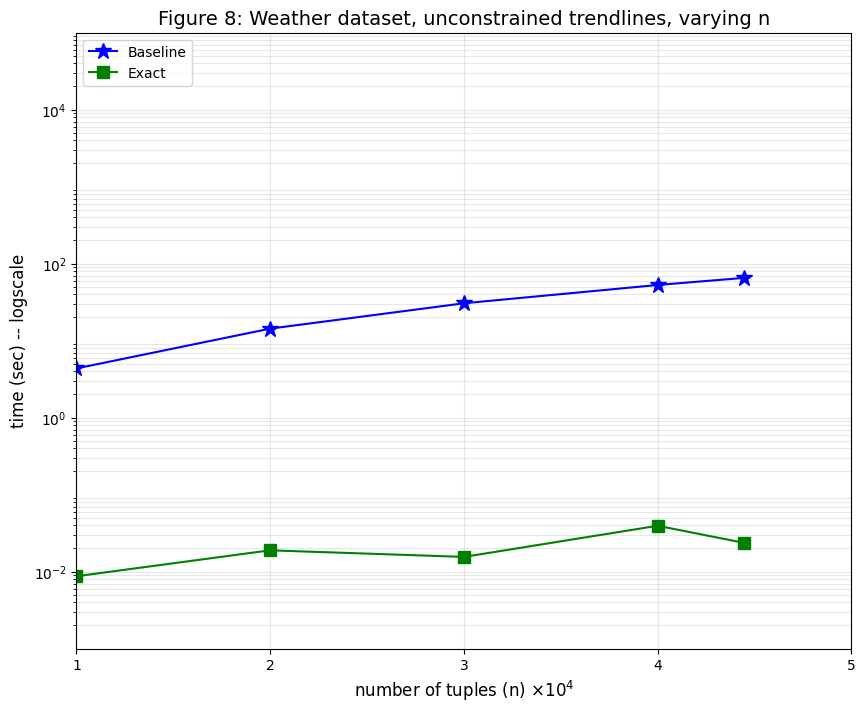

In [217]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import os
import numpy as np
from google.colab import drive

# 1. Load Data
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/DM-Project/temperature.csv'
df = pd.read_csv(file_path)
city_data = df['New York'].dropna().values

# 2. Setup based on Section 7.3.1
# Dividing the dataset into two equal non-overlapping halves
half = len(city_data) // 2
Rb_pool = city_data[:half]
Re_pool = city_data[half:]

# Total n values (sum of Rb and Re)
# 10,000 total means 5,000 from each pool
n_values = [10000, 20000, 30000, 40000, len(city_data)]
baseline_times = []
exact_times = []

for n in n_values:
    # Each region gets n/2 as per the "two equal-sized partitions" rule
    size_per_region = n // 2
    Rb = Rb_pool[:size_per_region]
    Re = Re_pool[:size_per_region]

    # Measure Baseline O(n^2)
    start = time.time()
    algorithm1_baseline(Rb, Re, bot='increase')
    baseline_times.append(time.time() - start)

    # Measure Exact O(n log n)
    start = time.time()
    algorithm2_exact(Rb, Re, bot='increase')
    exact_times.append(time.time() - start)

# 3. Final Plotting (Figure 8 Exact Design)
plt.figure(figsize=(10, 8))

# Markers and Colors strictly following Figure 8
plt.plot(n_values, baseline_times, label='Baseline', marker='*',
         markersize=12, color='blue', linestyle='-', linewidth=1.5)
plt.plot(n_values, exact_times, label='Exact', marker='s',
         markersize=8, color='green', linestyle='-', linewidth=1.5)

# --- Axis Formatting (Matches Paper Exactly) ---
plt.yscale('log')
plt.yticks([1e-2, 1e0, 1e2, 1e4], [r'$10^{-2}$', r'$10^0$', r'$10^2$', r'$10^4$'])
plt.ylim(1e-3, 1e5)

# Formatting X-axis to show 1, 2, 3, 4, 5 (units of 10^4)
plt.xticks([10000, 20000, 30000, 40000, 50000], ['1', '2', '3', '4', '5'])
plt.xlim(10000, 50000)

plt.xlabel(r'number of tuples (n) $\times 10^4$', fontsize=12)
plt.ylabel('time (sec) -- logscale', fontsize=12)
plt.title('Figure 8: Weather dataset, unconstrained trendlines, varying n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.3)

plt.show()

# **Support Measurement - figure 5**

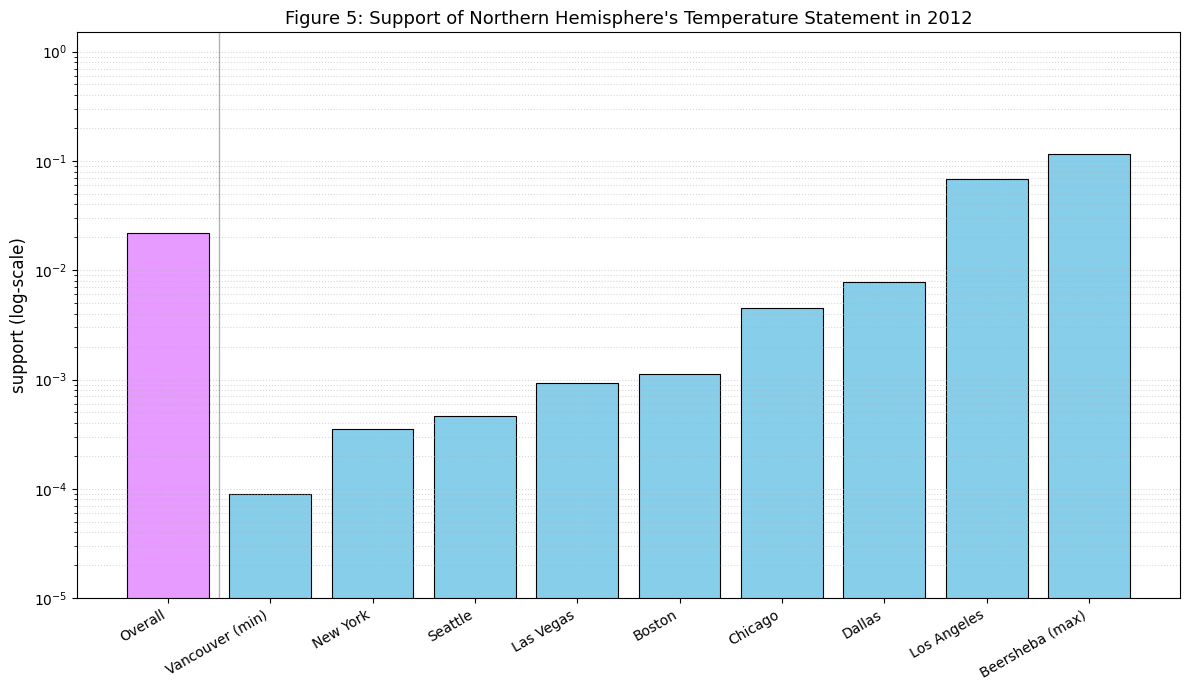

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. הגדרת התקופות המדויקות (Example 1)
winter_mask = (df['datetime'] >= '2012-12-01') & (df['datetime'] <= '2013-03-01')
summer_mask = (df['datetime'] >= '2013-06-01') & (df['datetime'] <= '2013-09-01')

# 2. רשימת הערים וחישוב ה-Support לכל אחת
target_cities = ['Vancouver', 'New York', 'Seattle', 'Las Vegas', 'Boston', 'Chicago', 'Dallas', 'Los Angeles', 'Beersheba']
city_results = []

for city in target_cities:
    Rb = df.loc[winter_mask, city].dropna().values
    Re = df.loc[summer_mask, city].dropna().values
    # הטענה: קיץ קר מחורף (x_e < x_b)
    omega = algorithm2_exact(Rb, Re, bot='decrease')
    city_results.append(omega)

# 3. חישוב ה-Overall (ממוצע ה-Support של כל הערים)
overall_support = np.mean(city_results)

# 4. הכנת הנתונים לציור בסדר הנכון
final_labels = ['Overall'] + [
    'Vancouver (min)', 'New York', 'Seattle', 'Las Vegas',
    'Boston', 'Chicago', 'Dallas', 'Los Angeles', 'Beersheba (max)'
]
final_values = [overall_support] + city_results

# 5. יצירת הגרף המעוצב
plt.figure(figsize=(12, 7))
colors = ['#e79aff'] + ['skyblue'] * (len(final_labels) - 1) # עמודת Overall מודגשת יותר
bars = plt.bar(final_labels, final_values, color=colors, edgecolor='black', linewidth=0.8)

# הגדרת ציר Y לוגריתמי בדיוק לפי המאמר
plt.yscale('log')
plt.ylim(10**-5, 1.5)
plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
           [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^0$'])

# תוויות ועיצוב
plt.ylabel('support (log-scale)', fontsize=12)
plt.title('Figure 5: Support of Northern Hemisphere\'s Temperature Statement in 2012', fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', which="both", ls=":", alpha=0.5)

# הוספת קו מפריד דמיוני לעמודת ה-Overall כפי שרואים לפעמים במאמרים
plt.axvline(x=0.5, color='black', linestyle='-', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

CH

# **cherry-picked trendlines - Bitcoin Dataset**

Detecting "Statistical Lies" in Market Extremes: We applied our algorithms to identify misleading trendlines during famous market cycles, such as the 2018 crash and the 2017 bull run


We developed two distinct cases to show the contrast between a singular "cherry-picked" trendline and the actual global trend:

The "Fake Bull Market" (2018): Finding an upward trendline during a period of a massive price drop.
The "Fake Bear Market" (2017): Identifying a downward trendline during a year of unprecedented growth.

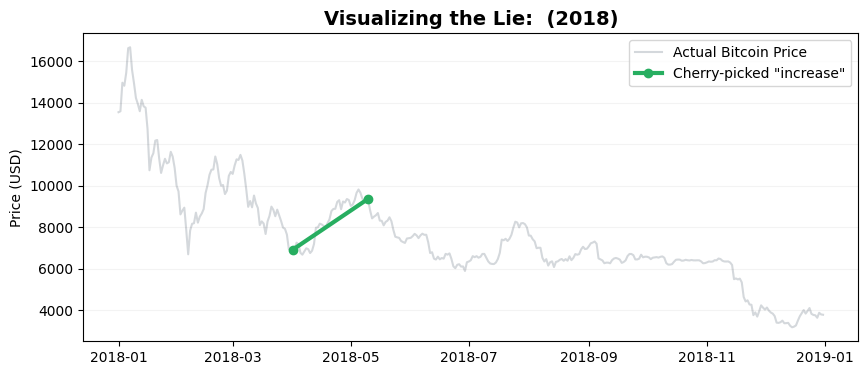

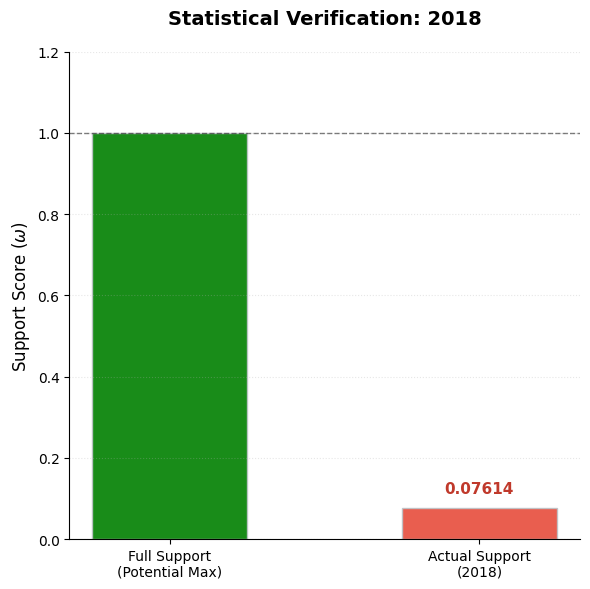

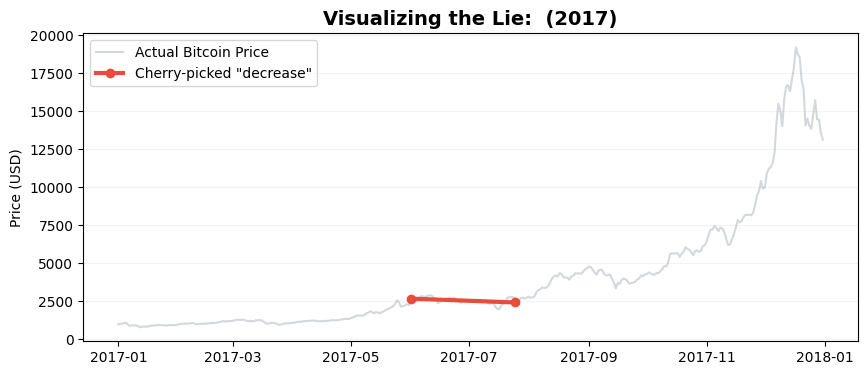

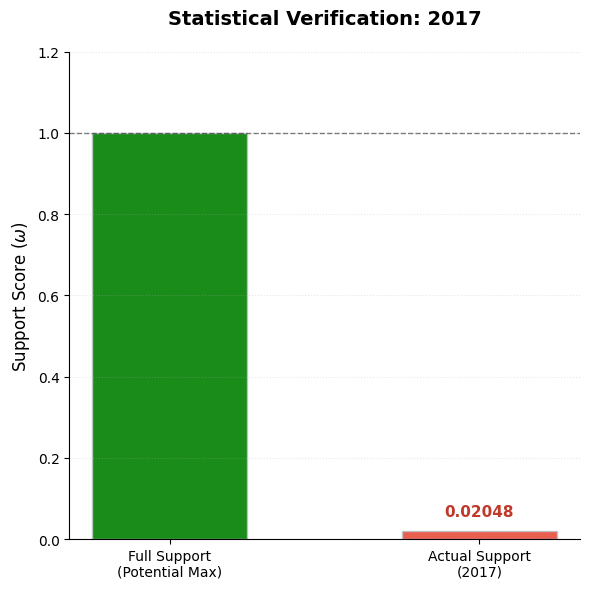

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bisect

# --- 1. האלגוריתם המדויק (Exact Support Calculation) ---
def algorithm2_exact(Rb, Re, bot='increase'):
    """
    מחשב את ציון התמיכה המדויק (ω) בין שני טווחי נתונים.
    """
    if len(Rb) == 0 or len(Re) == 0:
        return 0

    Rb_sorted = sorted(Rb)
    n_b = len(Rb_sorted)
    count = 0

    for y_te in Re:
        if bot == 'increase':
            count += bisect.bisect_left(Rb_sorted, y_te)
        else: # decrease
            idx = bisect.bisect_right(Rb_sorted, y_te)
            count += (n_b - idx)

    return count / (len(Rb) * len(Re))

# --- 2. פונקציית גרף הקו (The Visual Lie) ---
def plot_visual_lie(df, title, claim_type, year):
    """
    מציג את קו המגמה המטעה על פני נתוני המחיר השנתיים.
    """
    start_date, end_date = f'{year}-01-01', f'{year}-12-31'
    df_p = df[(df['Timestamp'] >= pd.to_datetime(start_date)) & (df['Timestamp'] <= pd.to_datetime(end_date))].copy()

    if year == 2018:
        rb_r, re_r = ('2018-04-01', '2018-04-10'), ('2018-05-01', '2018-05-10')
        line_color = '#27ae60'
    else:
        rb_r, re_r = ('2017-06-01', '2017-06-15'), ('2017-07-10', '2017-07-25')
        line_color = '#e74c3c'

    Rb = df_p[(df_p['Timestamp'] >= pd.to_datetime(rb_r[0])) & (df_p['Timestamp'] <= pd.to_datetime(rb_r[1]))]['Close'].values
    Re = df_p[(df_p['Timestamp'] >= pd.to_datetime(re_r[0])) & (df_p['Timestamp'] <= pd.to_datetime(re_r[1]))]['Close'].values

    plt.figure(figsize=(10, 4))
    plt.plot(df_p['Timestamp'], df_p['Close'], color='#2c3e50', alpha=0.2, label='Actual Bitcoin Price')
    plt.plot([pd.to_datetime(rb_r[0]), pd.to_datetime(re_r[1])], [np.mean(Rb), np.mean(Re)],
             color=line_color, linestyle='-', linewidth=3, marker='o', label=f'Cherry-picked "{claim_type}"')

    plt.title(f"Visualizing the Lie: {title} ({year})", fontsize=14, fontweight='bold')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(axis='y', alpha=0.15)
    plt.show()

# --- 3. פונקציית עמודת ה-Support עם עמודת ייחוס (Linear) ---
def plot_global_support_bar(df, title, claim_type, year):
    """
    מציג את התמיכה הסטטיסטית בסקאלה ליניארית עם עמודת ייחוס להשוואה.
    """
    start_date, end_date = f'{year}-01-01', f'{year}-12-31'
    df_p = df[(df['Timestamp'] >= pd.to_datetime(start_date)) & (df['Timestamp'] <= pd.to_datetime(end_date))].copy()

    mid_point = len(df_p) // 2
    Rb_global = df_p.iloc[:mid_point]['Close'].values
    Re_global = df_p.iloc[mid_point:]['Close'].values
    omega_val = algorithm2_exact(Rb_global, Re_global, bot=claim_type)

    plt.figure(figsize=(6, 6))

    # שתי עמודות: אחת לשם השוואה (1.0) והשנייה לתוצאה שלנו
    labels = ['Full Support\n(Potential Max)', f'Actual Support\n({year})']
    values = [1.0, omega_val]
    # אפור בהיר לעמודת הייחוס, אדום לתוצאה הממשית
    colors = ['green', '#e74c3c']

    plt.bar(labels, values, color=colors, edgecolor='#bdc3c7', width=0.5, alpha=0.9)

    # שימוש בסקאלה ליניארית להמחשת הפער העצום
    plt.yscale('linear')
    plt.ylim(0, 1.2)
    plt.ylabel(r'Support Score ($\omega$)', fontsize=12)

    plt.title(f"Statistical Verification: {year}", fontsize=14, fontweight='bold', pad=20)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', ls=":", alpha=0.3)

    # הוספת קו 1.0 בולט
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    # הצגת הערך המדויק
    status_text = f'{omega_val:.5f}' if omega_val > 0 else "ZERO SUPPORT"
    plt.text(1, omega_val + 0.03, status_text, ha='center', va='bottom',
             fontweight='bold', color='#c0392b', fontsize=11)

    plt.tight_layout()
    plt.show()

# --- 4. הרצת הניתוח ---
if 'df_btc' in locals():
    df_btc['Timestamp'] = pd.to_datetime(df_btc['Timestamp'])

    # מקרה 1: 2018 (התרסקות)
    plot_visual_lie(df_btc, "", "increase", 2018)
    plot_global_support_bar(df_btc, "2018 Global Support Analysis", "increase", 2018)

    # מקרה 2: 2017 (נסיקה)
    plot_visual_lie(df_btc, "", "decrease", 2017)
    plot_global_support_bar(df_btc, "2017 Global Support Analysis", "decrease", 2017)